tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


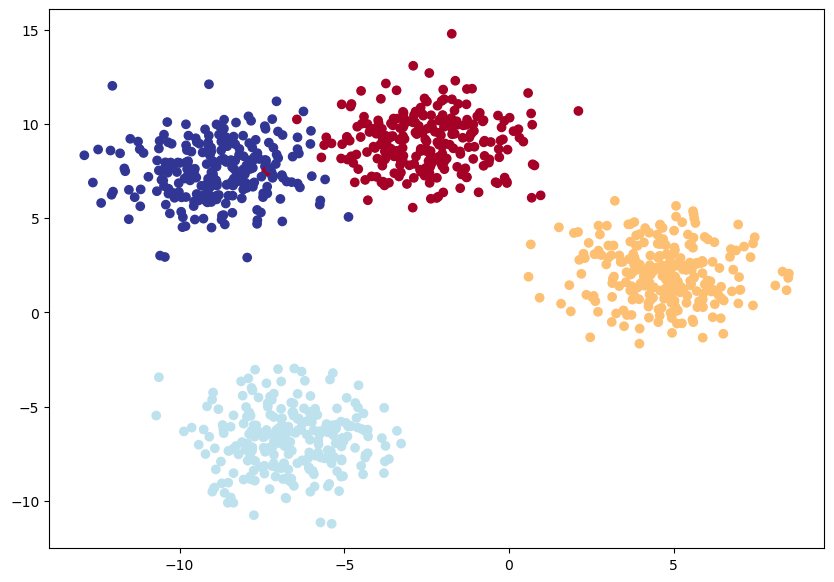

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU,
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [6]:
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.6519,  0.0665,  0.0495, -0.3851],
        [ 0.0290, -2.7510, -0.3436, -3.1324],
        [-0.0114,  0.7156,  0.7257,  1.8451],
        [ 0.0670,  0.0341,  0.4644,  0.7272],
        [ 0.0253, -2.3167, -0.2106, -2.5114]], grad_fn=<SliceBackward0>)

In [7]:
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [8]:
y_logits = model_4(X_blob_test.to(device))
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[ 0.6051, -0.2824, -0.0212, -0.7853],
         [-0.2758, -3.0355, -0.2077, -2.9308],
         [ 0.1145,  0.8156,  0.6644,  1.7372],
         [ 0.6024,  0.3475,  0.1698,  0.1100],
         [ 0.1810, -2.4784, -0.3722, -3.0482]], grad_fn=<SliceBackward0>),
 tensor([[0.4555, 0.1875, 0.2435, 0.1134],
         [0.4537, 0.0287, 0.4857, 0.0319],
         [0.1019, 0.2054, 0.1766, 0.5162],
         [0.3295, 0.2554, 0.2138, 0.2014],
         [0.5936, 0.0415, 0.3414, 0.0235]], grad_fn=<SliceBackward0>))

In [9]:
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [10]:
torch.argmax(y_pred_probs[0])

tensor(0)

In [11]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
torch.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        model_4.eval()
        with torch.inference_mode():
            test_logits = model_4(X_blob_test)
            test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_blob_test)
            test_acc = accuracy_fn(y_blob_test, test_preds)
        
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")   

Epoch: 0 | Loss: 1.38747, Acc: 70.38% | Test Loss: 0.82463, Test Acc: 75.00%
Epoch: 10 | Loss: 0.14530, Acc: 99.38% | Test Loss: 0.13122, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08284, Acc: 99.25% | Test Loss: 0.07518, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06076, Acc: 99.12% | Test Loss: 0.05350, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04992, Acc: 99.12% | Test Loss: 0.04249, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04361, Acc: 99.12% | Test Loss: 0.03594, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03954, Acc: 99.12% | Test Loss: 0.03162, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03672, Acc: 99.12% | Test Loss: 0.02858, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03466, Acc: 99.12% | Test Loss: 0.02633, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03310, Acc: 99.12% | Test Loss: 0.02459, Test Acc: 99.50%


In [19]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.9369,  10.3620, -11.5484,  -8.4364],
        [  1.5383, -13.5164,  -0.3973,   7.0589],
        [ -7.7702, -11.9413,  19.1785,  10.6602],
        [  2.3025,   8.1030,  -5.5652,  -5.8487],
        [  6.8793,   1.8468, -14.2929,  -4.4406],
        [  1.5085, -16.7596,   0.1970,   8.9541],
        [ -7.5399,  -8.4974,  18.1238,   8.5513],
        [  5.3061,  -2.1606, -10.2847,  -1.3537],
        [ -8.7065, -17.4994,  22.0833,  14.3374],
        [  5.7734,  -0.6615, -11.5258,  -2.4496]])

In [20]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


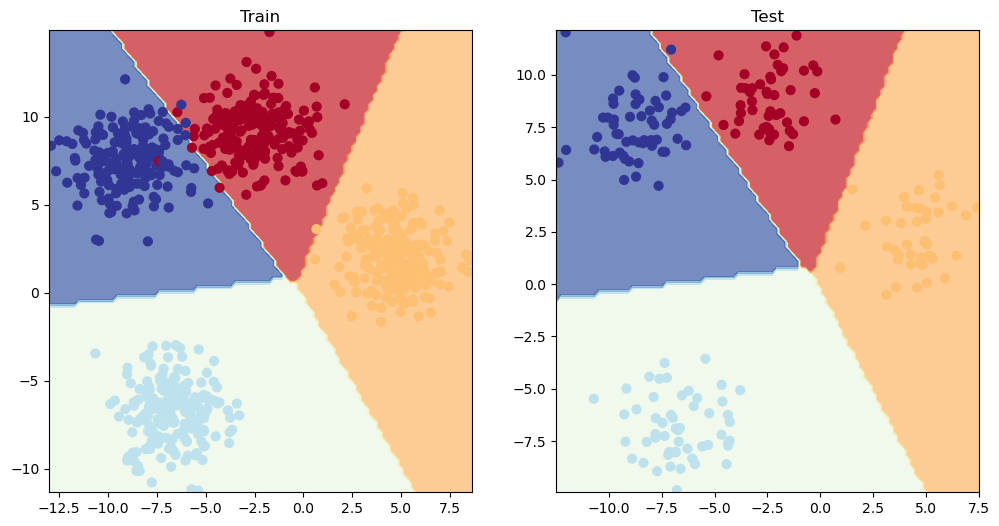

In [22]:
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [23]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 4.8 MB/s eta 0:00:00a 0:00:01


In [24]:
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)